### Distracted Driver Detection

#### Import Modules

In [1]:
# IMPORT MODULES
# Import Sys, Remove Path
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [56]:
# IMPORT MODULES
# Import Numpy, Keras and OpenCV etc
import numpy as np 
import pickle
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential, Input
from keras import layers
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, \
                                       ZeroPadding2D,Conv2D
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import model_from_json
from numpy.random import permutation
import keras
import keras.backend as K 
from keras.models import Model
from keras.layers import Dense, Dropout, Add, Input, BatchNormalization, Activation
from keras.layers import  Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.regularizers import l2
from keras.initializers import glorot_uniform
import cv2
import matplotlib.pyplot as plt
import glob
import os
print(os.listdir("../Data/Unzipped-Data/"))
%matplotlib inline

['imgs.zip', 'driver_imgs_list.csv', 'imgs', 'sample_submission.csv']


#### Load Data

In [3]:
# LOAD DATA
# Initialize
img_rows = 160
img_cols = 120

In [4]:
# LOAD DATA
# Read CSV File
df = pd.read_csv("../Data/Unzipped-Data/driver_imgs_list.csv")

In [5]:
# LOAD DATA
# Print
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [45]:
# LOAD DATA
# Define a Function to Load Image
def load_image(path, rows=None, cols=None, gray=True):
    if gray:
        img = cv2.imread(path,0)
    else:
        img = cv2.imread(path)
    img = cv2.resize(img,(160,120))
    return img

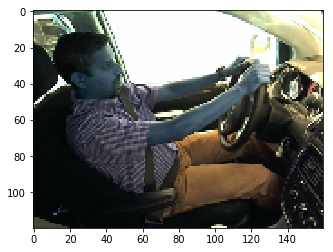

In [46]:
# LOAD DATA
# Load a Random Image
filename = "../Data/Unzipped-Data/imgs/train/c0/img_34.jpg"
image = load_image(filename, rows=None, cols=None, gray=False)

# Plot
plt.imshow(image)

In [8]:
# LOAD DATA
# Define a Function to Load Data
def load_data(split=0.33, rows=None, cols=None):
    paths = glob.glob(os.path.join("../Data/Unzipped-Data/imgs/", "train", "*",  "*.jpg"))
    labels = [int(x.split('/')[5][1]) for x in paths]
    if rows != None and cols != None:
        images = [load_image(x, rows, cols,gray=False) for x in paths]
    else:
        images = [load_image(x, gray=False) for x in paths]
    y = to_categorical(labels)
    x_train, x_test, y_train, y_test = train_test_split(images, y, test_size=split)
    
    return np.array(x_train), np.array(x_test), y_train, y_test

In [9]:
# LOAD Data
# Load Training and Testing Dataset
x_train, x_test, y_train, y_test = load_data(rows=img_rows, cols=img_cols)

#### Define Model

In [59]:
# Define Model
# Define Identity Block
def IdentityBlock(X,F,Filters,Stage,Block):    
    # Defining Name Basis
    ConvNameBase='Res'+str(Stage)+Block+'_Branch'
    BnNameBase='Bn'+str(Stage)+Block+'_Branch'
    
    # Retrieve Filters
    F1,F2,F3=Filters
    
    # Save the Input Value 
    XShortcut=X
    
    # First Component of Main Path
    X=Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid',name=ConvNameBase+'2a',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2a')(X)
    X=Activation('relu')(X)

    # Second Component of Main Path
    X=Conv2D(filters=F2,kernel_size=(F,F),strides=(1,1),padding='same',name=ConvNameBase+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2b')(X)
    X=Activation('relu')(X)

    # Third component of Main Path
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=ConvNameBase+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2c')(X)

    # Add Shortcut Value to Main Path, and Pass it through a RELU Activation
    X=Add()([X,XShortcut])
    X=Activation('relu')(X)
    
    # Return    
    return X

In [60]:
# DEFINE MODEL
# Define Convolutional Block
def ConvolutionalBlock(X,F,Filters,Stage,Block,S=2):    
    # Defining Name Basis
    ConvNameBase='Res'+str(Stage)+Block+'_Branch'
    BnNameBase='Bn'+str(Stage)+Block+'_Branch'
    
    # Retrieve Filters
    F1,F2,F3=Filters
    
    # Save the Input Value 
    XShortcut=X

    # First Component of Main Path 
    X=Conv2D(F1,(1,1),strides=(S,S),name=ConvNameBase+'2a',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2a')(X)
    X= Activation('relu')(X)
    
    # Second Component of Main Path
    X=Conv2D(F2,(F,F),strides=(1,1),padding='same',name=ConvNameBase+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2b')(X)
    X=Activation('relu')(X)

    # Third component of Main Path
    X=Conv2D(F3,(1,1),strides=(1,1),name=ConvNameBase+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2c')(X)

    # Shortcut Path
    XShortcut=Conv2D(F3,(1,1),strides=(S,S),name =ConvNameBase+'1',kernel_initializer=glorot_uniform(seed=0))(XShortcut)
    XShortcut=BatchNormalization(axis=3,name=BnNameBase+'1')(XShortcut)
  
    # Add Shortcut Value to Main Path, and Pass it through a RELU Activation
    X=Add()([X,XShortcut])
    X=Activation('relu')(X)
    
    # Return
    return X

In [61]:
# RESNET50 MODEL
# Define ResNet50 Model
def ResNet50(InputShape=(64,64,3),Classes=6):    
    # Define the Input as a Tensor
    XInput=Input(InputShape)
    
    # Zero-Padding
    X=ZeroPadding2D((3,3))(XInput)
    
    # Stage 1
    X=Conv2D(64,(7,7),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name='bn_conv1')(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((3,3),strides=(2,2))(X)

    # Stage 2
    X=ConvolutionalBlock(X,F=3,Filters=[64,64,256],Stage=2,Block='a',S=1)
    X=IdentityBlock(X,3,[64,64,256],Stage=2,Block='b')
    X=IdentityBlock(X,3,[64,64,256],Stage=2,Block='c')

    # Stage 3 
    X=ConvolutionalBlock(X,F=3,Filters=[128,128,512],Stage=3,Block='a',S=2)
    X=IdentityBlock(X,3,[128,128,512],Stage=3,Block='b')
    X=IdentityBlock(X,3,[128,128,512],Stage=3,Block='c')
    X=IdentityBlock(X,3,[128,128,512],Stage=3,Block='d')

    # Stage 4 (≈6 lines)
    X=ConvolutionalBlock(X, F = 3, Filters = [256, 256, 1024], Stage = 4, Block='a', S = 2)
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='b')
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='c')
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='d')
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='e')
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='f')

    # Stage 5 (≈3 lines)
    X=ConvolutionalBlock(X,F=3,Filters=[512,512,2048],Stage=5,Block='a',S=2)
    X=IdentityBlock(X,3,[512,512,2048],Stage=5,Block='b')
    X=IdentityBlock(X,3,[512,512,2048],Stage=5,Block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X=AveragePooling2D(pool_size=(2,2),name='avg_pool')(X)

    # output layer
    X=Flatten()(X)
    X=Dense(Classes,activation='softmax',name='fc'+str(Classes),kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    ResNetModel=Model(inputs=XInput,outputs=X,name='ResNet50')

    return ResNetModel

#### Train Model

In [12]:
# TRAIN MODEL
# Print Input Data Size
print(x_train[0].shape)

(120, 160, 3)

In [17]:
# TRAIN MODEL
# Initialize Model
model = ResNet50(InputShape = (120, 160, 3), Classes=10)
model.compile("adam","categorical_crossentropy", ['accuracy'])

In [63]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 120, 160, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, 126, 166, 3)   0           input_6[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 60, 80, 64)    9472        zero_padding2d_3[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 60, 80, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

In [64]:
# TRAIN MODEL
# Evaluate Accuracy of Untrained Model
model.evaluate(x_test,y_test)

7400/7400 [==============================] - 45s    


[14.495395052110826, 0.10067567567567567]

In [65]:
# TRAIN MODEL
# Train and Validate Model
model.fit(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_test, y_test))

Train on 15024 samples, validate on 7400 samples
Epoch 1/10
15024/15024 [==============================] - 359s - loss: 1.9739 - acc: 0.4631 - val_loss: 1.0618 - val_acc: 0.6827
Epoch 2/10
15024/15024 [==============================] - 358s - loss: 0.2356 - acc: 0.9289 - val_loss: 0.1585 - val_acc: 0.9543
Epoch 3/10
15024/15024 [==============================] - 358s - loss: 0.1259 - acc: 0.9607 - val_loss: 0.1227 - val_acc: 0.9658
Epoch 4/10
15024/15024 [==============================] - 358s - loss: 0.1407 - acc: 0.9579 - val_loss: 0.1148 - val_acc: 0.9666
Epoch 5/10
15024/15024 [==============================] - 357s - loss: 0.0689 - acc: 0.9795 - val_loss: 0.1241 - val_acc: 0.9649
Epoch 6/10
15024/15024 [==============================] - 357s - loss: 0.0721 - acc: 0.9791 - val_loss: 0.1135 - val_acc: 0.9674
Epoch 7/10
15024/15024 [==============================] - 357s - loss: 0.0617 - acc: 0.9821 - val_loss: 0.1358 - val_acc: 0.9588
Epoch 8/10
15024/15024 [========================

In [66]:
# TRAIN MODEL
# Evaluate Model
model.evaluate(x_test, y_test)

7400/7400 [==============================] - 45s    


[0.13789236312581074, 0.9686486486486486]

In [67]:
# TRAIN MODEL
# Save the Model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialize Weights to HDF5
model.save_weights("weights.h5")

Result: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


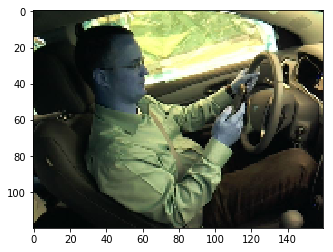

In [75]:
# TRAIN MODEL
# Test Model
plt.imshow(x_test[11])
print("Result:", np.around(model.predict(x_test[11:12])))